<a href="https://colab.research.google.com/github/salochaud/aprendizajeautomatico/blob/main/Tarea_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 5 – Agrupamiento

Para la presente tarea se seleccionó el uso del algoritmo **DBSCAN** (*Density-Based Spatial Clustering of Applications with Noise*) aplicado al conjunto de datos de rendimiento de jugadores NBA.

DBSCAN agrupa puntos que están densamente conectados en el espacio de características y etiqueta como ruido los puntos en zonas de baja densidad.

- Un punto `p` es *core* si su vecindad `N_eps(p)` contiene al menos `min_samples` puntos.

- Dos puntos están directamente conectados por densidad si uno está dentro de la vecindad de radio `eps` del otro y al menos uno es *core*.

- La conectividad por densidad extiende esto transitivamente y define *clusters* como componentes conectadas por densidad.

- Los puntos que no pertenecen a ningún cluster se marcan con la etiqueta `-1` (ruido).

Donde:

- `eps` — radio de vecindad.

- `min_samples` — número mínimo de puntos dentro de `eps` para considerar un punto *core*.

**Ventajas**

* No se necesita fijar `k` (número de clusters) por adelantado.

* Detecta clusters de forma arbitraria (no asume esferas ni hiperplanos).

* Maneja ruido/outliers (jugadores con estadísticas muy atípicas).

* Es útil cuando hay zonas densas (rendimientos muy similares) y zonas dispersas.

**Limitaciones**

* Se necesita elegir `eps` y `min_samples`.

* Si las densidades de los clusters varían mucho, DBSCAN puede fallar.

## Estrategia para determinar número de grupos

En este caso se utiliza el gráfico de **k-distance** (distancia al k-ésimo vecino más cercano) para elegir un valor adecuado de `eps`.

1. Se estandarizan las variables numéricas.

2. Para cada punto se calcula la distancia a su k-ésimo vecino.

3. Se ordenan estas distancias y se grafican.

4. El punto donde la curva presenta un "codo" indica un valor razonable para `eps`. A partir de ahí, las distancias crecen rápidamente y los puntos empiezan a considerarse ruido o a formar nuevos grupos muy pequeños.


In [1]:


import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)


df = pd.read_csv("/content/database_24_25.csv")

display(df.head())
print(df.columns)

,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,...,4,4,10,1,1,1,1,37,38.1,2024-10-22
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,...,13,16,4,1,3,1,1,36,34.0,2024-10-22
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,...,3,3,4,1,0,0,1,24,22.4,2024-10-22
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,...,2,4,4,1,0,0,2,18,19.5,2024-10-22
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,...,0,0,2,0,0,1,1,22,17.8,2024-10-22


Index(['Player', 'Tm', 'Opp', 'Res', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'GmSc', 'Data'],
      dtype='object')


## Selección de variables numéricas

Se seleccionan como variables de entrada (`X`) las estadísticas numéricas relacionadas con el rendimiento del jugador en cada partido.

In [2]:

cols_num = [
    'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%',
    'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc'
]

X = df[cols_num].copy()
display(X.head())

print("Shape de X:", X.shape)

,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
0,30.30,14,18,0.778,8,11,0.727,1,2,0.500,0,4,4,10,1,1,1,1,37,38.1
1,37.58,11,23,0.478,1,3,0.333,13,15,0.867,3,13,16,4,1,3,1,1,36,34.0
2,26.63,8,13,0.615,6,10,0.600,2,2,1.000,0,3,3,4,1,0,0,1,24,22.4
3,30.52,7,9,0.778,4,6,0.667,0,0,0.000,2,2,4,4,1,0,0,2,18,19.5
4,25.85,8,10,0.800,4,5,0.800,2,3,0.667,0,0,0,2,0,0,1,1,22,17.8


Shape de X: (16512, 20)


## Estandarización de los datos

DBSCAN es sensible a la escala de las variables, por lo que se aplica **StandardScaler** para que todas las características tengan media 0 y desviación estándar 1.

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[ 0.72453307,  3.11786675,  1.60234834,  1.37477976,  4.43024225,
         2.38671526,  1.61837709, -0.25653293, -0.00628419,  0.18878208,
        -0.748994  ,  0.34156132, -0.02848301,  2.88745498,  0.23210144,
         0.63828513, -0.19167559, -0.52155845,  2.99902914,  3.77491466],
       [ 1.39264884,  2.19642435,  2.4259019 ,  0.19798641, -0.16412427,
        -0.15165338,  0.24201898,  5.11666593,  4.82861919,  1.0309937 ,
         1.43837581,  3.6534982 ,  3.42123381,  0.59161752,  0.23210144,
         3.03823139, -0.19167559, -0.52155845,  2.88576893,  3.25070781],
       [ 0.38772197,  1.27498194,  0.77879478,  0.7353887 ,  3.1175661 ,
         2.06941918,  1.17472867,  0.19123364, -0.00628419,  1.33620935,
        -0.748994  , -0.02643167, -0.31595941,  0.59161752,  0.23210144,
        -0.561688  , -0.89157549, -0.52155845,  1.5266464 ,  1.76758599],
       [ 0.74472338,  0.96783447,  0.11995193,  1.37477976,  1.80488995,
         0.80023486,  1.40877941, -0.7042995 , -

## k-distance plot

Se calcula la distancia al k-ésimo vecino más cercano para cada punto y se grafica para identificar un posible valor de `eps`.

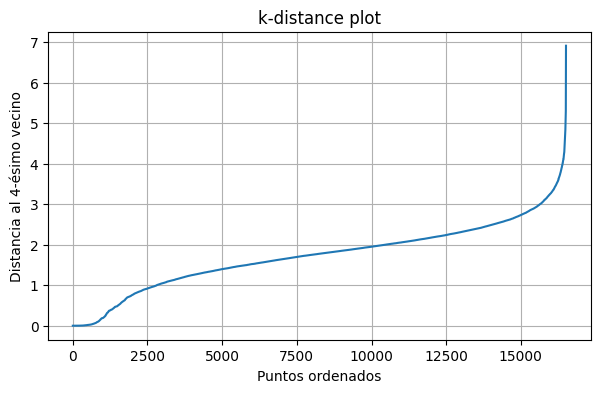

In [4]:
k = 4  # recomendado que coincida con min_samples en DBSCAN
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Tomar la distancia k-ésima de cada punto y ordenarla
k_dist = np.sort(distances[:, k-1])

plt.figure(figsize=(7, 4))
plt.plot(k_dist)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}-ésimo vecino")
plt.title("k-distance plot")
plt.grid(True)
plt.show()

Tras observar el gráfico de k-distance, se debe elegir un valor de `eps` cercano al 'codo' de la curva. Ese valor puede ajustarse de forma empírica hasta obtener un número razonable de clusters (ni demasiados ni todos en uno solo).

In [5]:
# Valor inicial de eps (AJUSTAR después de ver el gráfico k-distance)
eps = 1.5
eps

1.5

## DBSCAN

Se aplica el algoritmo DBSCAN con los parámetros `eps` y `min_samples = k`. Los puntos etiquetados como `-1` serán considerados ruido.

In [6]:
dbscan = DBSCAN(eps=eps, min_samples=k)
labels = dbscan.fit_predict(X_scaled)

# Agregar etiquetas al DataFrame original
df['dbscan_labels'] = labels
display(df[['Player', 'Tm', 'Opp', 'PTS', 'GmSc', 'dbscan_labels']].head())

# Resumen de clusters
unique, counts = np.unique(labels, return_counts=True)
cluster_summary = pd.DataFrame({'label': unique, 'count': counts}).sort_values('label')
display(cluster_summary)

# Número de clusters (sin contar ruido)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Número de clusters (sin ruido):", n_clusters)

,Player,Tm,Opp,PTS,GmSc,dbscan_labels
0,Jayson Tatum,BOS,NYK,37,38.1,-1
1,Anthony Davis,LAL,MIN,36,34.0,-1
2,Derrick White,BOS,NYK,24,22.4,-1
3,Jrue Holiday,BOS,NYK,18,19.5,-1
4,Miles McBride,NYK,BOS,22,17.8,-1


,label,count
0,-1,9594
1,0,6707
2,1,3
3,2,4
4,3,4
5,4,6
6,5,16
7,6,4
8,7,9
9,8,4


Número de clusters (sin ruido): 44


## Visualización de los clusters con PCA

Se aplica PCA para reducir las dimensiones a 2 componentes principales y así poder visualizar los grupos encontrados por DBSCAN.

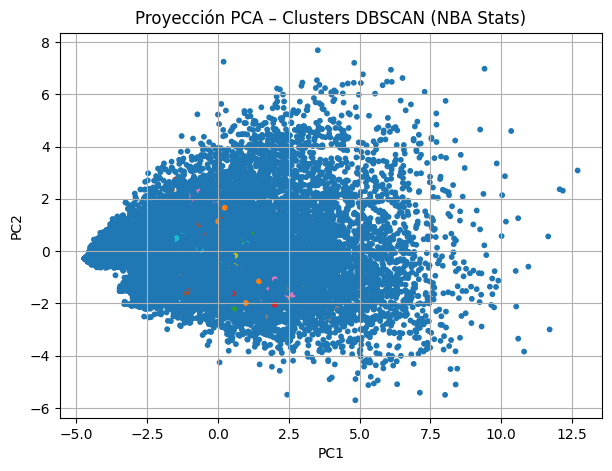

In [7]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Proyección PCA – Clusters DBSCAN (NBA Stats)")
plt.grid(True)
plt.show()

## Análisis de los grupos

Se calculan los promedios de algunas variables clave por cluster para interpretar las estructuras encontradas (por ejemplo, jugadores con alto puntaje, buenos reboteadores, especialistas defensivos, etc.).

In [8]:
# Promedios por cluster (incluyendo ruido si se desea)
cluster_means = df.groupby('dbscan_labels')[['PTS', 'GmSc', 'TRB', 'AST', 'STL', 'BLK']].mean()
cluster_means

,PTS,GmSc,TRB,AST,STL,BLK
dbscan_labels,,,,,,
-1,15.065249,12.622629,5.636231,3.450907,1.073692,0.706275
0,3.978977,2.762994,1.916058,1.031609,0.341434,0.135083
1,7.000000,1.266667,1.333333,0.333333,0.333333,0.000000
2,8.500000,2.725000,2.500000,2.000000,0.000000,0.000000
3,6.500000,7.175000,5.250000,2.000000,1.250000,0.000000
4,7.333333,5.900000,3.166667,0.666667,0.000000,0.000000
5,18.187500,13.856250,4.312500,2.000000,0.000000,0.000000
6,11.500000,12.350000,4.000000,0.750000,1.000000,1.000000
7,14.444444,12.255556,3.222222,3.666667,1.333333,0.000000
